In [1]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
env = gym.make('Blackjack-v1')

In [3]:
# Resetting with a seed once will make the subsequent starting observations the same.
observation, _ = env.reset(seed=42)
print(observation)
observation, _ = env.reset()
print(observation)
observation, _ = env.reset()
print(observation)

(15, 2, 0)
(13, 10, 0)
(20, 10, 0)


In [4]:
observation2state = lambda x: (x[0], x[1], int(x[2]))

def play_policy(env, policy=None, verbose=False):
    observation, _ = env.reset()
    #reward, terminated, truncated = 0, False, False
    episode_reward, elapsed_steps = 0, 0

    while True:
        if policy is None:
            action = env.action_space.sample()
        else:
            state = observation2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if terminated or truncated:
            break
    return episode_reward, elapsed_steps


In [5]:
episode_reward, elapsed_steps = play_policy(env, verbose=True)
episode_reward, elapsed_steps

(1.0, 2)

In [6]:
def test_policy(trials, env, policy=None):
    rewards = [play_policy(env, policy=policy)[0] for _ in tqdm(range(trials))]
    return np.mean(rewards), np.std(rewards)

In [7]:
test_policy(1000, env)

100%|██████████| 1000/1000 [00:00<00:00, 23866.80it/s]


(np.float64(-0.421), np.float64(0.8841713634810845))

## On-Policy Policy Evaluation
- No duplicate states in each trajectory/episode
- Only reward of last step is nonzero

These allow the following simplifications:
- Since every state will be visited only once, there is no need to distinguish between every-visit and first-visit.
- When discount factor $\gamma = 1$, the reward in the last step is the episode return. We do not need to calculate the episode return in reversed order.

In [8]:
def evaluate_action_mc_original(env, policy, episode_num=500000):
    q = np.zeros_like(policy)  # action value
    c = np.zeros_like(policy)  # count
    for _ in tqdm(range(episode_num)):
        # play an episode
        state_actions = []
        observation, _ = env.reset()
        while True:
            state = observation2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break  # end of episode
        g = reward  # return
        for state, action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g - q[state][action]) / c[state][action]
    return q

In [10]:
env.reset(seed=42)
policy = np.zeros((22, 11, 2, 2))
policy[20:, :, :, 0] = 1
policy[:20, :, :, 1] = 1
q = evaluate_action_mc_original(env, policy)
v = np.sum(q * policy, axis=-1)

100%|██████████| 500000/500000 [00:28<00:00, 17692.31it/s]


In [12]:
def plot(data):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    titles = ["without ace", "with ace"]
    have_aces = [0,1]
    extent = [12, 22, 1, 11]

    for title, have_ace, axis in zip(titles, have_aces, axes):
        dat = data[extent[0]: extent[1], extent[2]: extent[3], have_ace].T
        axis.imshow(dat, extent=extent, origin='lower')
        axis.set_xlabel("Player sum")
        axis.set_ylabel("Dealer sum")
        axis.set_title(title)

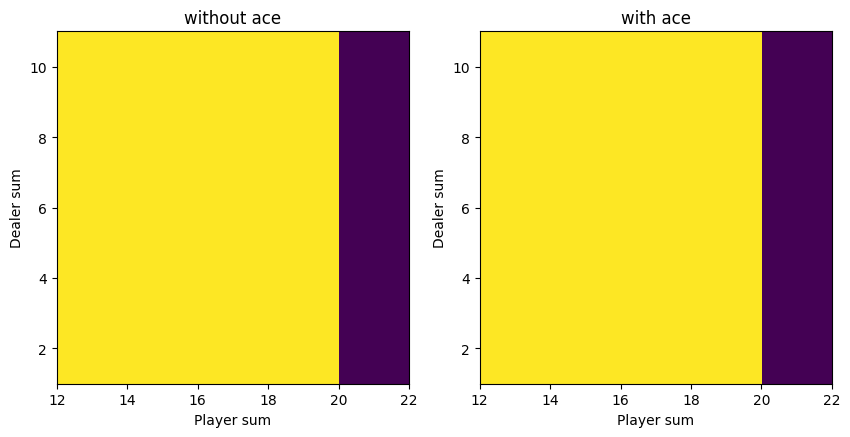

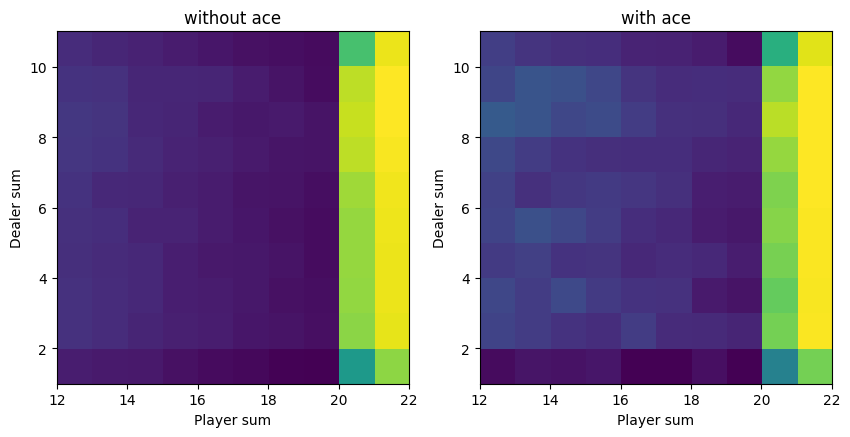

In [13]:
plot(policy.argmax(-1))
plot(v)

Notice we can hit without fear of busting if our card sum is below 12. Our focus should be on states where the player sum is 12 or higher.

In [19]:
def monte_carlo_with_exploring_start(env, episode_num=500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 1] = 1 # only hit no matter what
    q = np.zeros_like(policy)
    c = np.zeros_like(policy)
    for _ in tqdm(range(episode_num)):
        # choose iniital state randomly.
        state = (np.random.randint(12,22), np.random.randint(1,11), np.random.randint(2))
        action = np.random.randint(2)

        # Play episode
        env.reset()

        player_sum, has_ace = state[0], state[2]
        if has_ace:
            env.unwrapped.player = [1, player_sum - 1]
        else:
            if player_sum == 21:
                env.unwrapped.player = [10, 9, 2]
            else:
                env.unwrapped.player = [10, player_sum - 1 - 10]

        env.unwrapped.dealer[0] = state[1]
        state_actions = []

        while True:
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break

            state = observation2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])

        g = reward
        for state, action in state_actions:
            c[*state, action] += 1
            q[*state, action] += (g - q[*state, action]) / c[*state, action]

            a = q[state].argmax()
            policy[state] = 0
            policy[*state, a] = 1
    return policy, q

100%|██████████| 500000/500000 [00:24<00:00, 20804.93it/s]


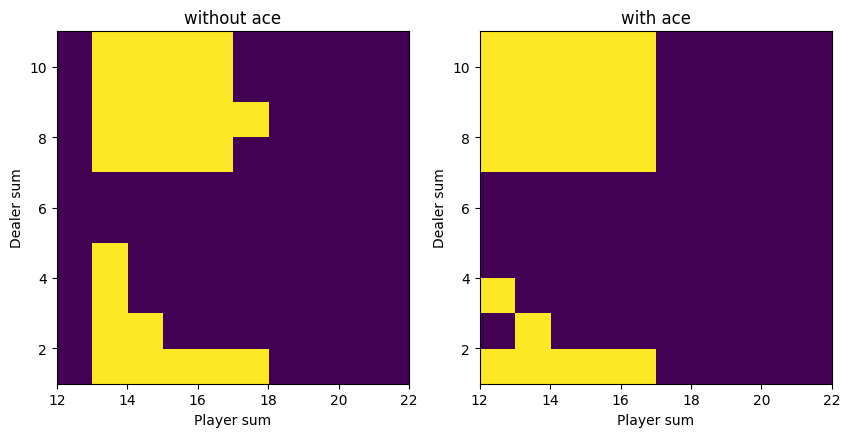

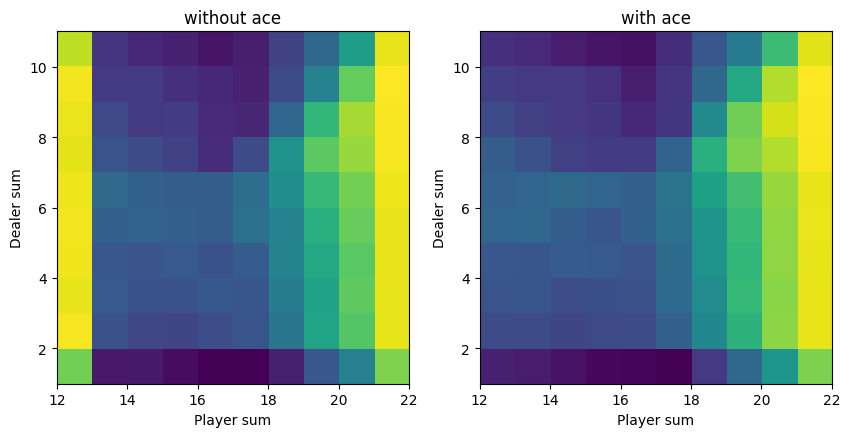

In [20]:
env.reset(seed=42)
policy, q = monte_carlo_with_exploring_start(env)
v = q.max(axis=-1)
plot(policy.argmax(-1))
plot(v)

In [21]:
test_policy(1000, env, policy)

100%|██████████| 1000/1000 [00:00<00:00, 20420.87it/s]


(np.float64(-0.03), np.float64(0.9597395480024775))

In [25]:
def monte_carlo_with_exploring_start(env, episode_num=500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 1] = 1.
    q = np.zeros_like(policy)  # action values
    c = np.zeros_like(policy)  # counts
    for _ in tqdm(range(episode_num)):
        # choose initial state randomly
        state = (np.random.randint(12, 22), np.random.randint(1, 11), np.random.randint(2))
        action = np.random.randint(2)
        # play an episode
        env.reset()
        if state[2]:  # has ace
            env.unwrapped.player = [1, state[0] - 11]
        else:  # no ace
            if state[0] == 21:
                env.unwrapped.player = [10, 9, 2]
            else:
                env.unwrapped.player = [10, state[0] - 10]
        env.unwrapped.dealer[0] = state[1]
        state_actions = []
        while True:
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break  # end of episode
            state = observation2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])

        g = reward  # return
        for state, action in state_actions:
            c[*state,action] += 1.
            q[*state,action] += (g - q[*state,action]) / c[*state,action]
            a = q[state].argmax()
            policy[state] = 0.
            policy[*state,a] = 1.
    return policy, q

100%|██████████| 500000/500000 [00:25<00:00, 19263.24it/s]


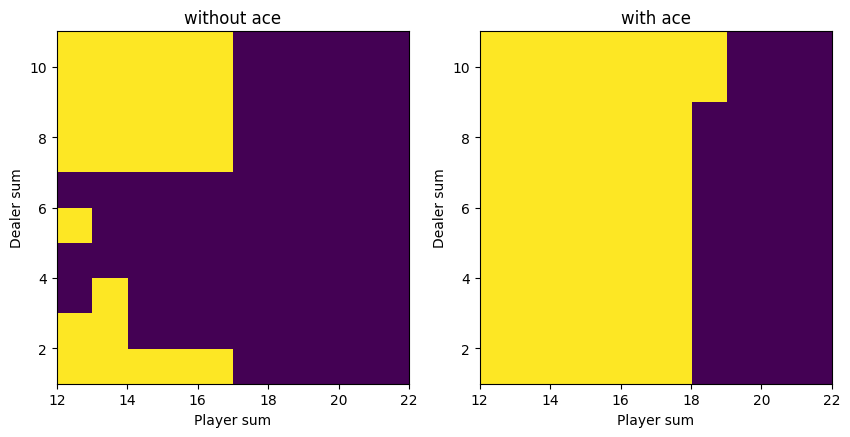

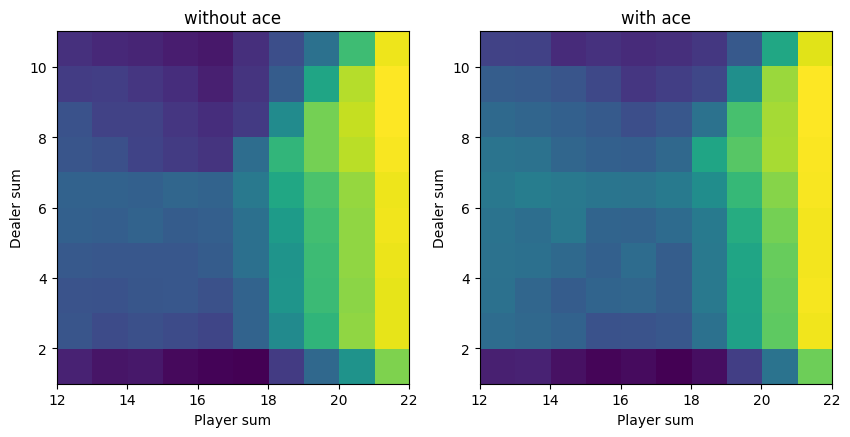

In [26]:
env.reset(seed=42)
policy, q = monte_carlo_with_exploring_start(env)
v = q.max(axis=-1)
plot(policy.argmax(-1))
plot(v)

In [27]:
test_policy(1000, env, policy)

100%|██████████| 1000/1000 [00:00<00:00, 17890.81it/s]


(np.float64(-0.073), np.float64(0.9411009510142896))

In [28]:
def monte_carlo_with_soft(env, episode_num=500000, epsilon=0.1):
    policy = np.ones((22, 11, 2, 2)) * 0.5  # soft policy
    q = np.zeros(policy.shape)  # action values
    c = np.zeros(policy.shape)  # counts
    for _ in tqdm(range(episode_num)):
        # play an episode
        state_actions = []
        observation, _ = env.reset()
        while True:
            state = observation2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break  # end of episode

        g = reward  # reward is only given at the end, so we don't have to deal with previous 0 rewards.
        for state, action in state_actions:
            c[*state,action] += 1.
            q[*state,action] += (g - q[*state,action]) / c[*state,action]

            # soft update
            a = q[state].argmax()
            policy[state] = epsilon / 2.
            policy[*state,a] += (1 - epsilon)
    return policy, q

100%|██████████| 500000/500000 [00:26<00:00, 18910.40it/s]


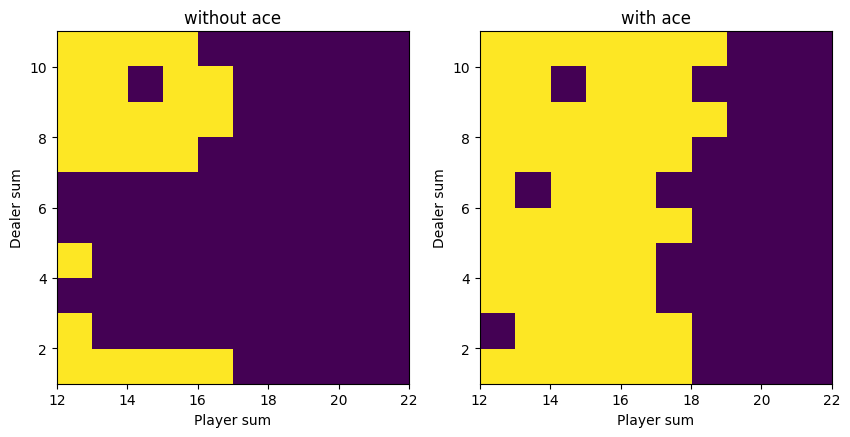

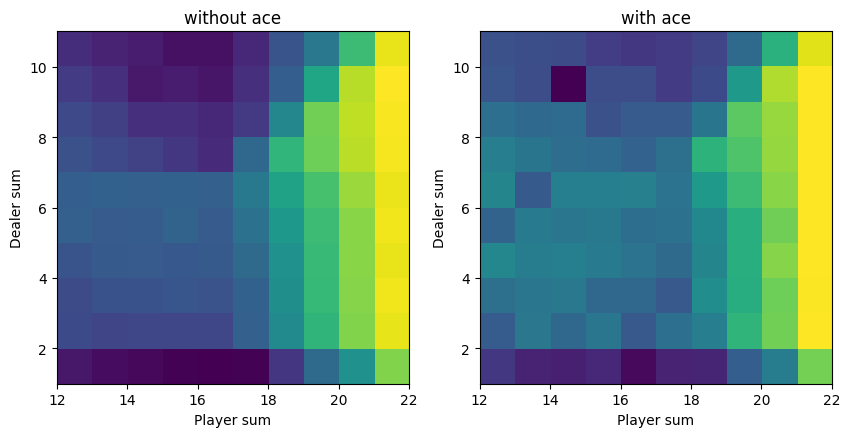

In [29]:
env.reset(seed=42)
policy, q = monte_carlo_with_soft(env)
v = q.max(axis=-1)
plot(policy.argmax(-1))
plot(v)

In [30]:
test_policy(1000, env, policy)

100%|██████████| 1000/1000 [00:00<00:00, 19479.94it/s]


(np.float64(-0.084), np.float64(0.9544338636071124))

In [31]:
def evaluate_monte_carlo_importance_sample(env, policy, behaviour_policy, episode_num=500000):
    q = np.zeros(policy.shape)
    c = np.zeros(policy.shape)
    for _ in tqdm(range(episode_num)):
        # Play episide using behaviour policy
        state_actions = []
        observation, _ = env.reset()
        while True:
            state = observation2state(observation)
            action = np.random.choice(env.action_space.n, p=policy[state])
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated: break

        g = reward
        rho = 1
        for state, action in reversed(state_actions):
            c[*state, action] += rho
            q[*state, action] += (rho / c[*state, action]) * (g - q[*state, action])
            rho *= policy[*state, action] / behaviour_policy[*state, action]
            if rho == 0:
                break # early stop
    return q

In [32]:
policy = np.zeros((22, 11, 2, 2))
policy[20:, :, :, 0] = 1
policy[:20, :, :, 1] = 1
behaviour_policy = np.ones(policy.shape) * 0.5

In [33]:
env.reset(seed=42)
q = evaluate_monte_carlo_importance_sample(env, policy, behaviour_policy)
v = (q * policy).sum(axis=-1)

100%|██████████| 500000/500000 [00:28<00:00, 17468.48it/s]


In [38]:
def monte_carlo_importance_sample(env, episode_num = 500000):
    policy = np.zeros((22, 11, 2, 2))
    policy[:, :, :, 0] = 1
    behaviour_policy = np.ones(policy.shape) * 0.5

    q = np.zeros(policy.shape)
    c = np.zeros(policy.shape)
    for _ in range(episode_num):
        state_actions = []
        observation, _ = env.reset()
        while True:
            state = observation2state(observation)
            action = np.random.choice(env.action_space.n, p=behaviour_policy[state])
            state_actions.append((state, action))
            observation, reward, terminated, truncated, _ = env.step(action)
            if terminated or truncated:
                break
        g = reward
        rho = 1
        for state, action in reversed(state_actions):
            c[*state, action] += rho
            q[*state, action] += rho / c[*state, action] * (g - q[*state, action])
            a = q[state].argmax()
            policy[state] = 0
            policy[*state, a] = 1
            if a != action:
                break # early stop
            rho /= behaviour_policy[*state, action]
    return policy, q

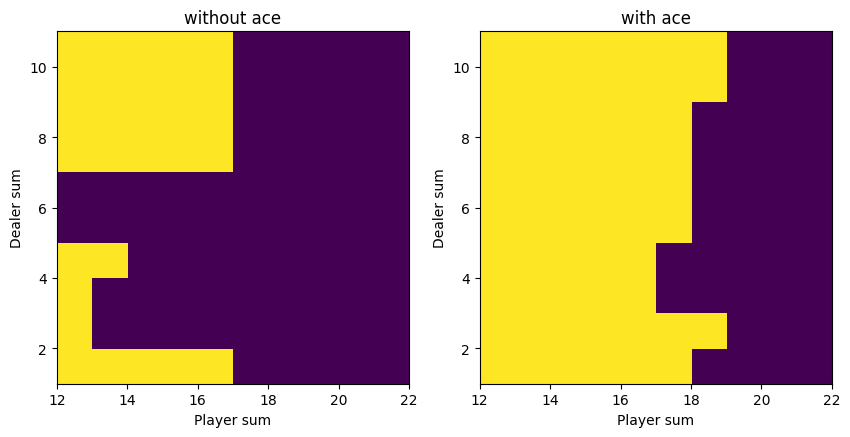

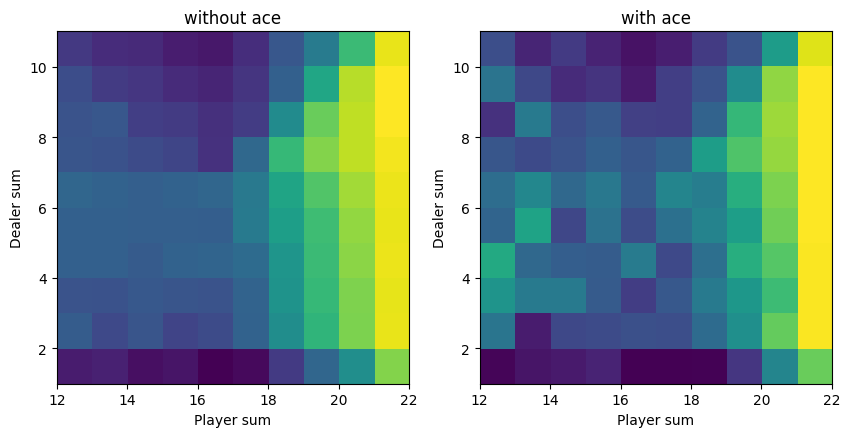

In [39]:
env.reset(seed=42)
policy, q = monte_carlo_importance_sample(env)
v = q.max(axis=-1)
plot(policy.argmax(-1))
plot(v)

In [40]:
test_policy(1000, env, policy)

100%|██████████| 1000/1000 [00:00<00:00, 14726.36it/s]


(np.float64(-0.033), np.float64(0.9538925516010698))